# Segy file - Basic attributes, headers parsing, and plotting

Please note that contents of this notebook were borowed from the web!

This notebook will go through the basics of segyio file handling. It covers:
- File reading
- Bin, text and trace headers parsing
- Trace headers quicklook
- Section (assuming the segy is a 2D poststack section)


### Dependencies

In [5]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segyio

filename = '''.\SEISMIC\94p07ful.sgy'''

## Utility functions

The following functions are defined to split the workflow into independant parts. They allow for the parsing of both text and traces headers into a dict and a pandas dataframe respectively.

In [6]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

## Get basic attributes and parse headers
The file reading is done within a *with* statement. The *ignore_geometry=True* argument is passed for non 3D specific segys.

In [7]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 116532, N Samples: 1001, Sample rate: 2.0ms'

The *twt* variable stores the two-way time for each sample.

In [8]:
bin_headers

{JobID: 0, LineNumber: 0, ReelNumber: 1636, Traces: 468, AuxTraces: 0, Interval: 2000, IntervalOriginal: -32768, Samples: 1001, SamplesOriginal: 51614, Format: 1, EnsembleFold: -13922, SortingCode: 4, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 21500, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 1, SEGYRevisionMinor: 0, TraceFlag: 1, ExtendedHeaders: 0}

In [9]:
text_headers

{'C01': '1 CLIENT                        COMPANY                       CREW NO ',
 'C02': '2 LINE            AREA                        MAP ID ',
 'C03': '3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER ',
 'C04': '4 INSTRUMENT: MFG            MODEL            SERIAL NO ',
 'C05': '5 DATA TRACES/RECORD        AUXILIARY TRACES/RECORD         CDP FOLD ',
 'C06': '6 SAMPLE INTERNAL         SAMPLES/TRACE       BITS/IN      BYTES/SAMPLE ',
 'C07': '7 RECORDING FORMAT        FORMAT THIS REEL        MEASUREMENT SYSTEM ',
 'C08': '8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORRELATED ',
 'C09': '9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND    -     HZ  SLOPE    -    DB/OCT C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL C12     PATTERN:                           LENGTH        WIDTH C13 SWEEP: START     HZ  END     HZ  LENGTH      MS  CHANNEL NO     TYPE C14 TAPER: START LENGTH       MS 

In [10]:
trace_headers.columns  # list the trace headers keys

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [11]:
trace_headers.head()

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2
1,1,1,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,0,0,2,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,3,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,4,0,0,0,4,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5,5,0,0,0,5,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Individual traces can then be accessed (e.g. get the FieldRecord number for the first trace):

In [12]:
trace_headers.loc[1, 'FieldRecord']

0

## Plotting Headers
Basic header QC might be achieved by plotting relevant values together. A quick example is shown here of creating a 2D header plot (without any meaning).

Text(0.5, 1.0, 'Basic Header QC')

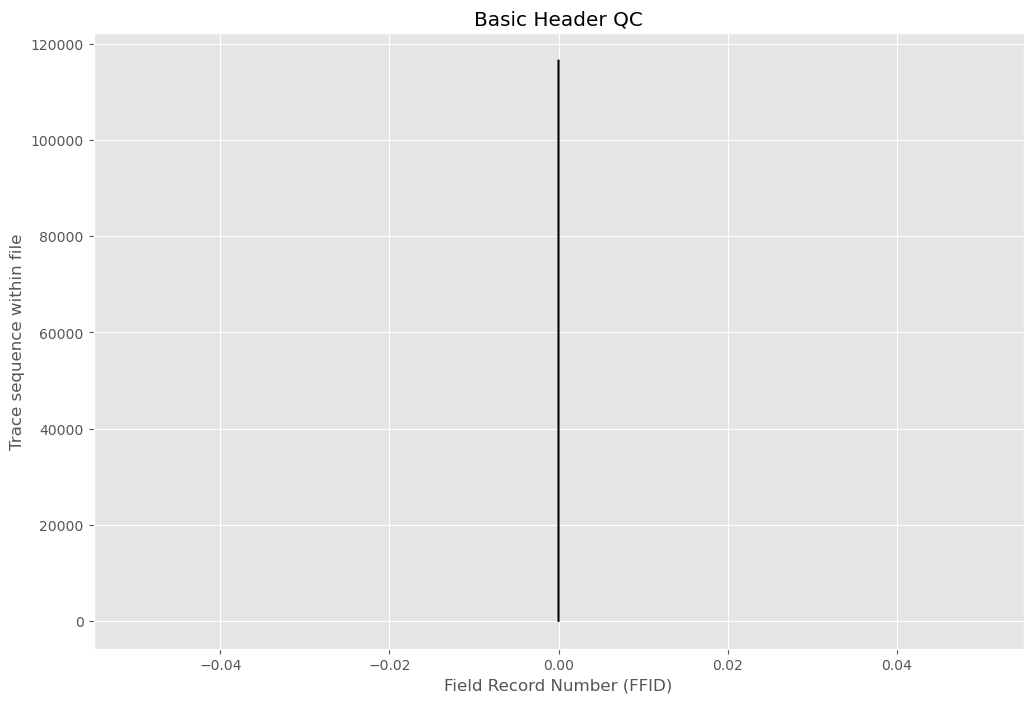

In [13]:
plt.style.use('ggplot')  # Use ggplot styles for all plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(trace_headers['FieldRecord'], trace_headers['TRACE_SEQUENCE_FILE'], '-k')
ax.set_xlabel('Field Record Number (FFID)')
ax.set_ylabel('Trace sequence within file')
ax.set_title('Basic Header QC')

## Plotting section
The straightforward way to display a segy file from segyio format is to use matplotlib.pyplot.imshow, which treats 2D arrays as images.

In order to scale and standardize the display, it is useful to get the nth percentile of the amplitudes

In [14]:
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

'The 99th percentile is 1; the max amplitude is 3'

Let's get to plotting!

Notice that we have to transpose the array to plot it like this. The reason is that we're storing things with traces in the first dimension ('rows' if you like), for convenience. This way data[0] refers to the first trace, not the first time sample. But imshow assumes that we're looking at a sort of image, with rows going across the image.

The extent of the image is also populated from the number of trace to display and the samples two-way times

Text(0.5, 1.0, '.\\SEISMIC\\94p07ful.sgy')

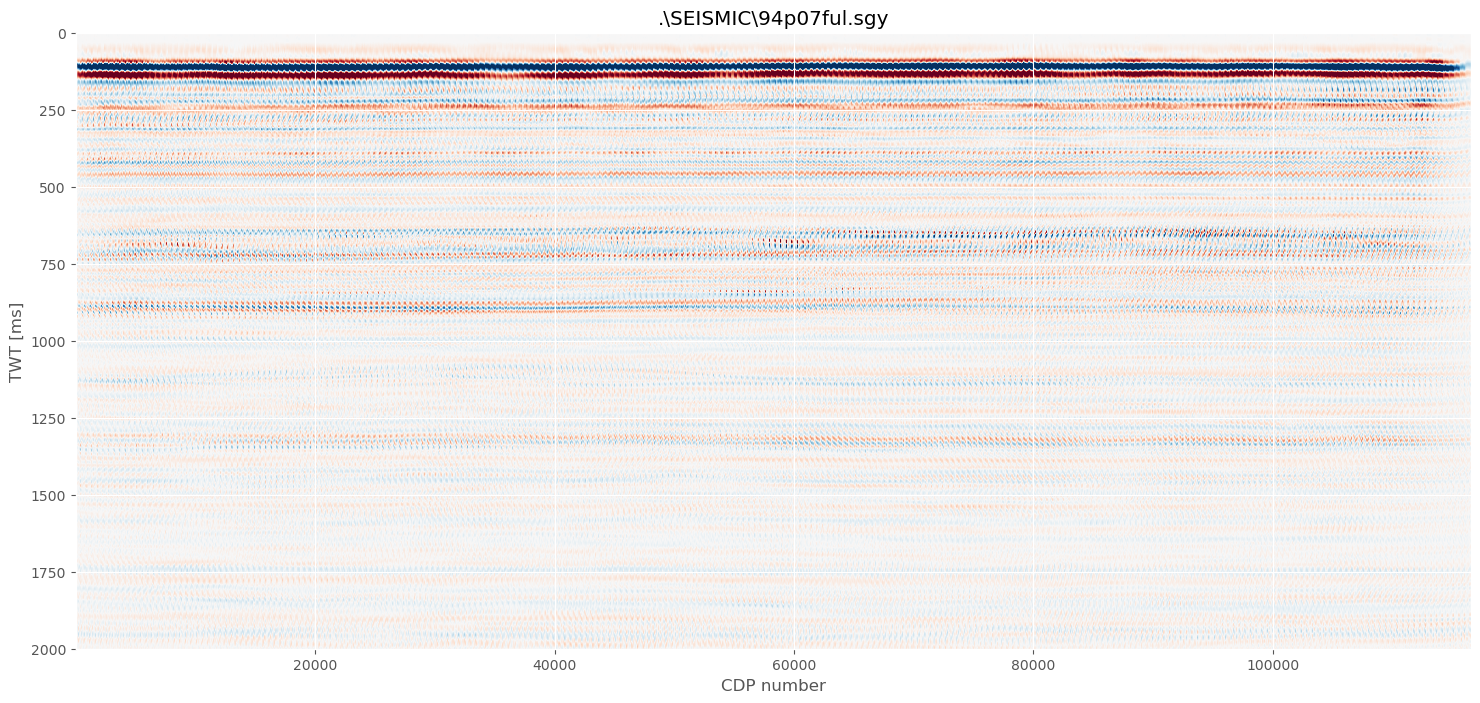

In [15]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'{filename}')